In [1]:
import numpy as np
import pandas as pd
import os, tensorflow as tf
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Layer

In [2]:
def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [3]:
base_path = "./garbage_classification/"

In [4]:
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'ต', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [5]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [6]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

In [26]:
df.lenght()

AttributeError: 'DataFrame' object has no attribute 'lenght'

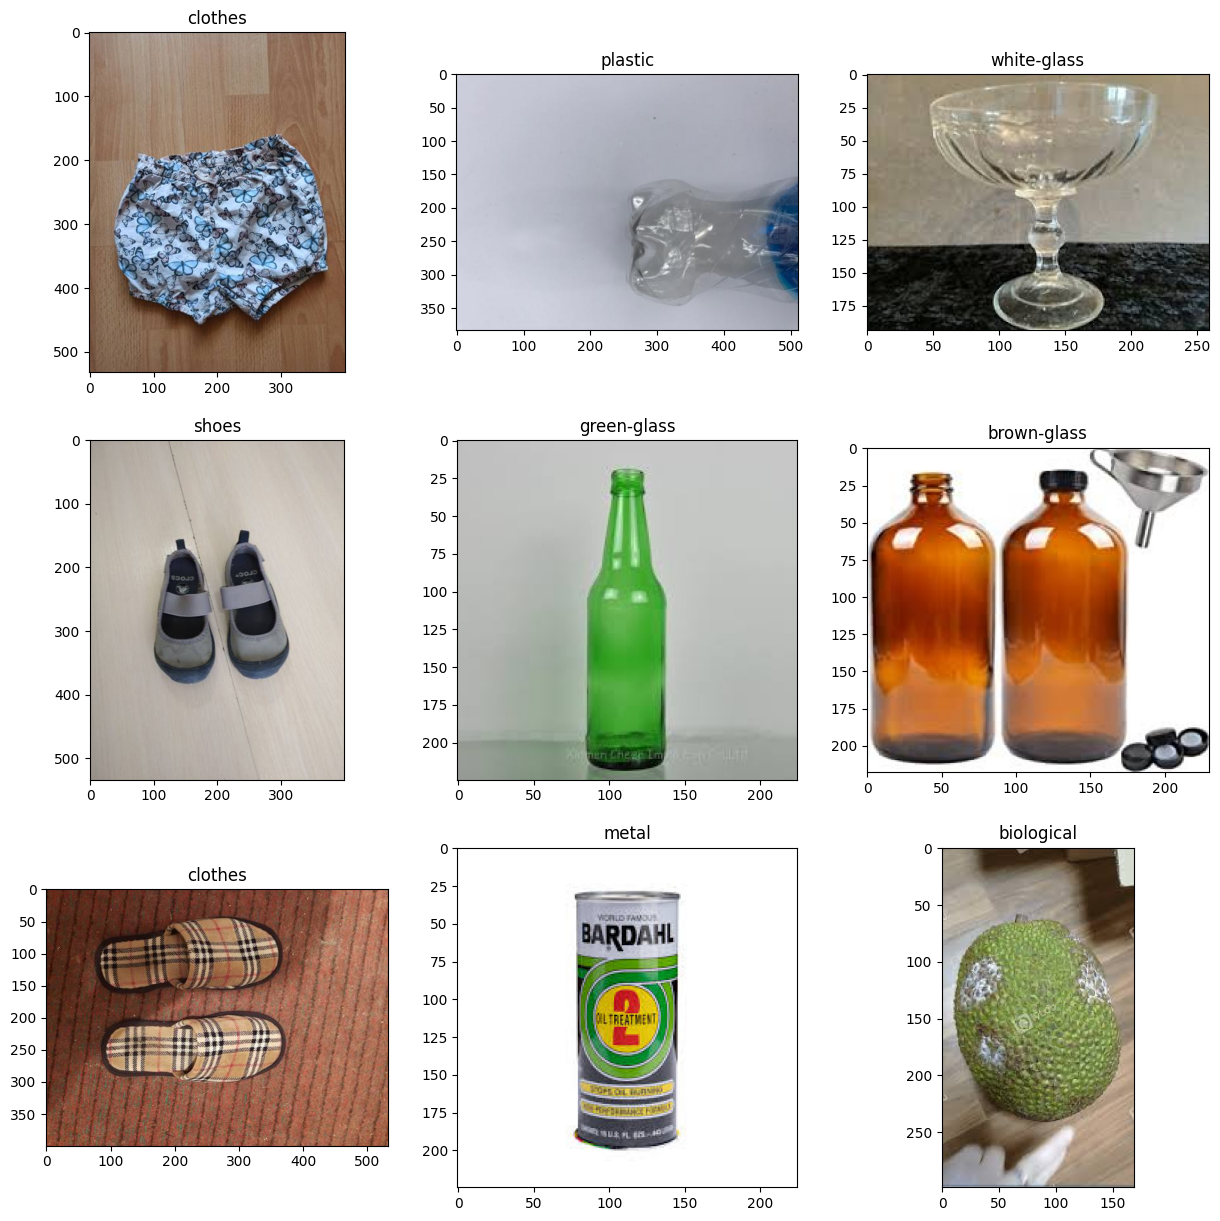

In [8]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

C:\Users\poomf\AppData\Local\Temp\ipykernel_9652\2274568390.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="category", data=df, palette='Blues')


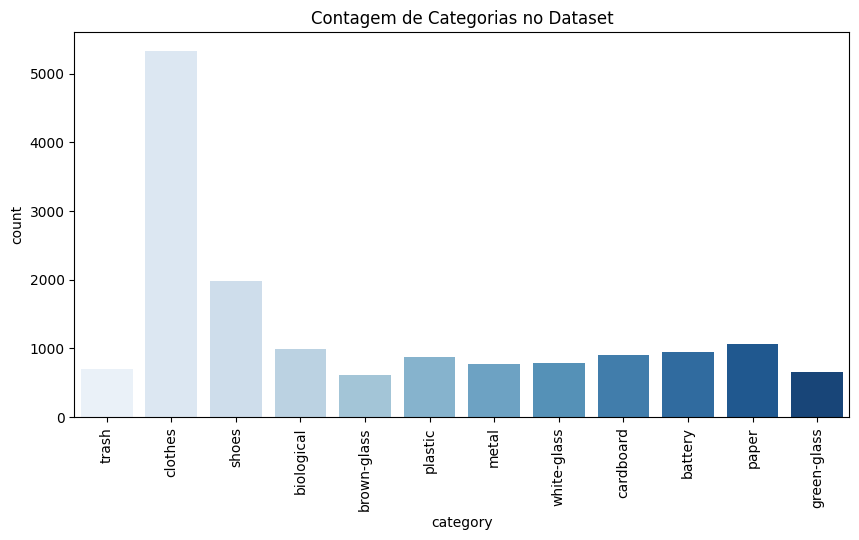

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Contagem de Categorias no Dataset')
plt.show()

In [10]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(12514, 1564, 1565)

In [12]:
train_df.head()

,filename,category
0,cardboard/cardboard381.jpg,cardboard
1,white-glass/white-glass717.jpg,white-glass
2,clothes/clothes4981.jpg,clothes
3,clothes/clothes3329.jpg,clothes
4,brown-glass/brown-glass470.jpg,brown-glass


In [13]:
im_shape = (256, 256)
batch_size = 64
seed = 12345

In [14]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 12412 validated image filenames belonging to 12 classes.


C:\Users\poomf\anaconda3\envs\dl_env\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 102 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [16]:
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 1549 validated image filenames belonging to 12 classes.


C:\Users\poomf\anaconda3\envs\dl_env\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 15 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [17]:
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 1554 validated image filenames belonging to 12 classes.


C:\Users\poomf\anaconda3\envs\dl_env\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 11 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [18]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [19]:
seed = 12345
set_seed(seed)

# model = Sequential()

# model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()


# -------------------------------------------

# from tensorflow.keras.applications import ResNet50

    # base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# for layer in base_model.layers:
#     layer.trainable = False

# model_resnet = Sequential([
#     base_model,
    
#     Conv2D(32, kernel_size=(2, 2), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, kernel_size=(2, 2), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
    
                 
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(12, activation='sigmoid')
# ])
# model_resnet.summary()


# -------------------------------------------

# model = Sequential()
# model.add(Conv2D(filters=32,kernel_size=3,
#                             padding='valid',activation='relu',input_shape=(im_shape[0], im_shape[1], 3)))
# model.add(MaxPooling2D(pool_size=2,strides=2))
# model.add(Flatten())
# model.add(Dense(40,activation='relu'))
# model.add(Dropout(rate= 0.1, seed= 100))
# model.add(Dense(units=12,activation='sigmoid'))
# model.summary()

# -------------------------------------------

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Load the MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)

# Add Global Average Pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add Fully Connected layer
predictions = Dense(12, activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [20]:
%%time
epochs = 20

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='modelMobileV2.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
193/193 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8742
Epoch 1: val_loss improved from inf to 0.79289, saving model to modelMobileV2.h5
193/193 [==============================] - 612s 3s/step - loss: 0.4255 - accuracy: 0.8742 - val_loss: 0.7929 - val_accuracy: 0.7559
Epoch 2/20
193/193 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9764
Epoch 2: val_loss did not improve from 0.79289
193/193 [==============================] - 599s 3s/step - loss: 0.0830 - accuracy: 0.9764 - val_loss: 0.8036 - val_accuracy: 0.7747
Epoch 3/20
193/193 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9934
Epoch 3: val_loss improved from 0.79289 to 0.55691, saving model to modelMobileV2.h5
193/193 [==============================] - 600s 3s/step - loss: 0.0287 - accuracy: 0.9934 - val_loss: 0.5569 - val_accuracy: 0.8379
Epoch 4/20
193/193 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9973
Epoch 4

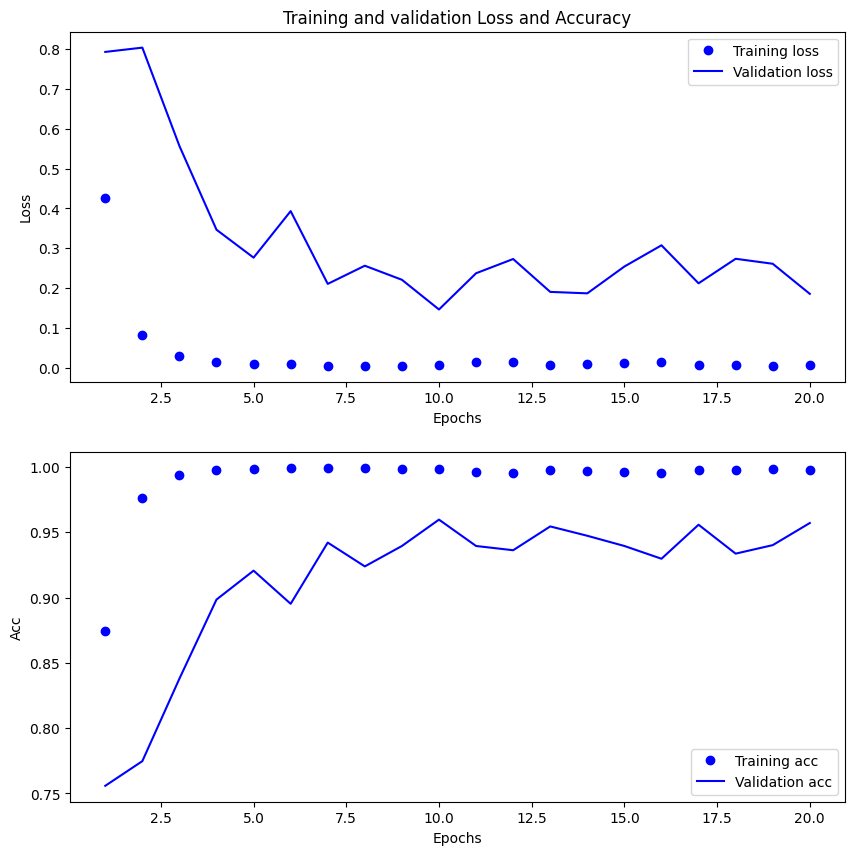

In [21]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [22]:
# model = load_model('../input/keras-simple-cnn-gargabe-classification/model.h5')
model = load_model('modelMobileV2.h5')

In [23]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

25/25 [==============================] - 15s 587ms/step - loss: 0.1494 - accuracy: 0.9587
Val loss: 0.14942046999931335
Val accuracy: 0.9586830139160156


In [24]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1554/1554 [==============================] - 37s 24ms/step - loss: 0.1719 - accuracy: 0.9505
Test loss: 0.1718912571668625
Test accuracy: 0.9504504799842834


['green2.jpg', 'IMG_6457.jpg', 'shoes.jpg', 'water2.jpg']
1/1 [==============================] - 0s 32ms/step


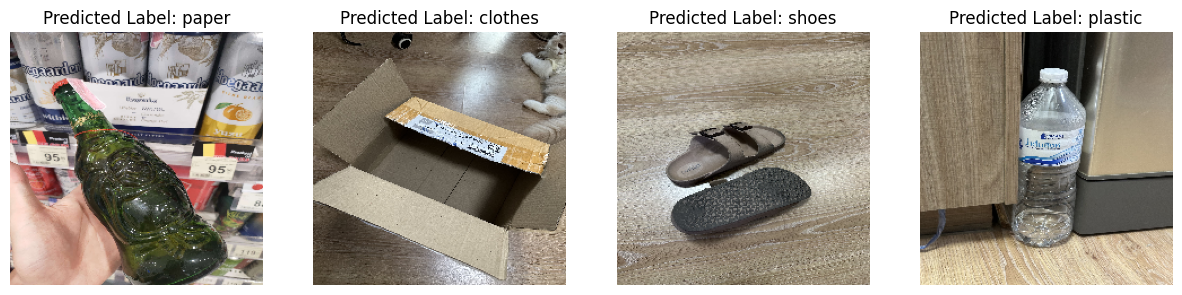

In [25]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# โหลดโมเดล CNN ที่ฝึกไว้
# model = load_model('your_model.h5')


img_height = 224
img_width = 224


# โหลดรูปภาพจากไดเรกทอรี
image_path = "./data/"
lists = os.listdir(image_path)
print(lists)

# สร้าง subplot
fig, axes = plt.subplots(1, len(lists), figsize=(15, 5))

for i, img_name in enumerate(lists):
    image_input = load_img((image_path+ img_name), target_size=(img_height, img_width))

    # แปลงรูปภาพเป็น NumPy array
    input_img_array = img_to_array(image_input)

    # ทำการปรับสีของรูปภาพ
    input_img_array = input_img_array.astype('float32') / 255

    # ทำการเรียงรูปภาพเพื่อให้เป็นลักษณะข้อมูลของโมเดล
    input_image = np.expand_dims(input_img_array, axis=0)

    # ทำการพยากรณ์ด้วยโมเดล CNN
    prediction = model.predict(input_image)

    # แสดงผลลัพธ์การพยากรณ์
    predicted_label = np.argmax(prediction)
    axes[i].imshow(image_input)
    axes[i].set_title("Predicted Label: {}".format(categories[predicted_label]))
    axes[i].axis('off')

plt.show()